
**Data Management Organization **

Members :
  
*   Jeffrey Wijaya       (2602158784)



In [10]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=05486e0a83a7566f1b0239ddfc777b54076e592cd3aff44e3fc52efa7419359a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Importing Data and Library

In [11]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.pipeline import Pipeline

In [12]:
filename = "Real estate.csv"

spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=',')
df.show()

+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
| No|X1 transaction date|X2 house age|X3 distance to the nearest MRT station|X4 number of convenience stores|X5 latitude|X6 longitude|Y house price of unit area|
+---+-------------------+------------+--------------------------------------+-------------------------------+-----------+------------+--------------------------+
|  1|           2012.917|        32.0|                              84.87882|                             10|   24.98298|   121.54024|                      37.9|
|  2|           2012.917|        19.5|                              306.5947|                              9|   24.98034|   121.53951|                      42.2|
|  3|           2013.583|        13.3|                              561.9845|                              5|   24.98746|   121.54391|                      47.3|
|  4|             2013.5|   

In [13]:
df.count()

414

# Exploratory Data Analysis (EDA)

*   Basic Statistics

In [14]:
df.describe().toPandas()


,summary,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,count,414,414,414,414,414,414,414,414
1,mean,207.5,2013.1489710144933,17.71256038647343,1083.8856889130436,4.094202898550725,24.969030072463745,121.53336108695667,37.98019323671498
2,stddev,119.6557562342907,0.2819672402629999,11.392484533242524,1262.109595407851,2.9455618056636177,0.012410196590450208,0.015347183004592374,13.606487697735316
3,min,1,2012.667,0.0,23.38284,0,24.93207,121.47353,7.6
4,max,414,2013.583,43.8,6488.021,10,25.01459,121.56627,117.5


In [15]:
df.printSchema()

root
 |-- No: integer (nullable = true)
 |-- X1 transaction date: double (nullable = true)
 |-- X2 house age: double (nullable = true)
 |-- X3 distance to the nearest MRT station: double (nullable = true)
 |-- X4 number of convenience stores: integer (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- Y house price of unit area: double (nullable = true)



In [16]:
df.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double')]

*   Missing Values and Cardinality Check



In [17]:
df.toPandas().isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [22]:
df.toPandas().nunique()

No                                        414
X1 transaction date                        12
X2 house age                              236
X3 distance to the nearest MRT station    259
X4 number of convenience stores            11
X5 latitude                               234
X6 longitude                              232
Y house price of unit area                270
dtype: int64

In [18]:
from pyspark.sql.functions import count, when, isnan, col

# miss_percentage is set to 80% as discussed in the book
def missing_calculation(df, miss_percentage=0.80):

    #checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True)
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True)
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df

    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage]

    return final_missing_df, vars_selected

In [19]:
missing_df, missing_vars_selected = missing_calculation(df)

In [20]:
missing_df

,index,missing_count,missing_percentage
0,No,0,0.0
1,X1 transaction date,0,0.0
2,X2 house age,0,0.0
3,X3 distance to the nearest MRT station,0,0.0
4,X4 number of convenience stores,0,0.0
5,X5 latitude,0,0.0
6,X6 longitude,0,0.0
7,Y house price of unit area,0,0.0


In [21]:
missing_vars_selected

Series([], Name: index, dtype: object)

# Data Cleaning and Preparation

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, when

# Assuming 'df' is your DataFrame
for column in df.columns:
    mean_value = df.select(mean(col(column)).alias('mean')).collect()[0]["mean"]
    mode_value = df.select(col(column)).groupBy(col(column)).count().orderBy('count', ascending=False).first()[0]
    if mean_value is not None:
        df = df.na.fill(mean_value, [column])


In [28]:
df.toPandas().isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

*   Label Encoding



In [29]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StringType

def index_string_columns(df):
    string_columns = [t[0] for t in df.dtypes if t[1] == 'string']
    for column in string_columns:
        indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
        df = indexer.fit(df).transform(df)
    return df

In [32]:
df = index_string_columns(df)

In [34]:
df.dtypes

[('No', 'int'),
 ('X1 transaction date', 'double'),
 ('X2 house age', 'double'),
 ('X3 distance to the nearest MRT station', 'double'),
 ('X4 number of convenience stores', 'int'),
 ('X5 latitude', 'double'),
 ('X6 longitude', 'double'),
 ('Y house price of unit area', 'double')]

In [35]:
# Count the number of duplicates in the DataFrame
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


**Displaying the relationship among numerical variables through pairplot visualization to showcase their correlations.**

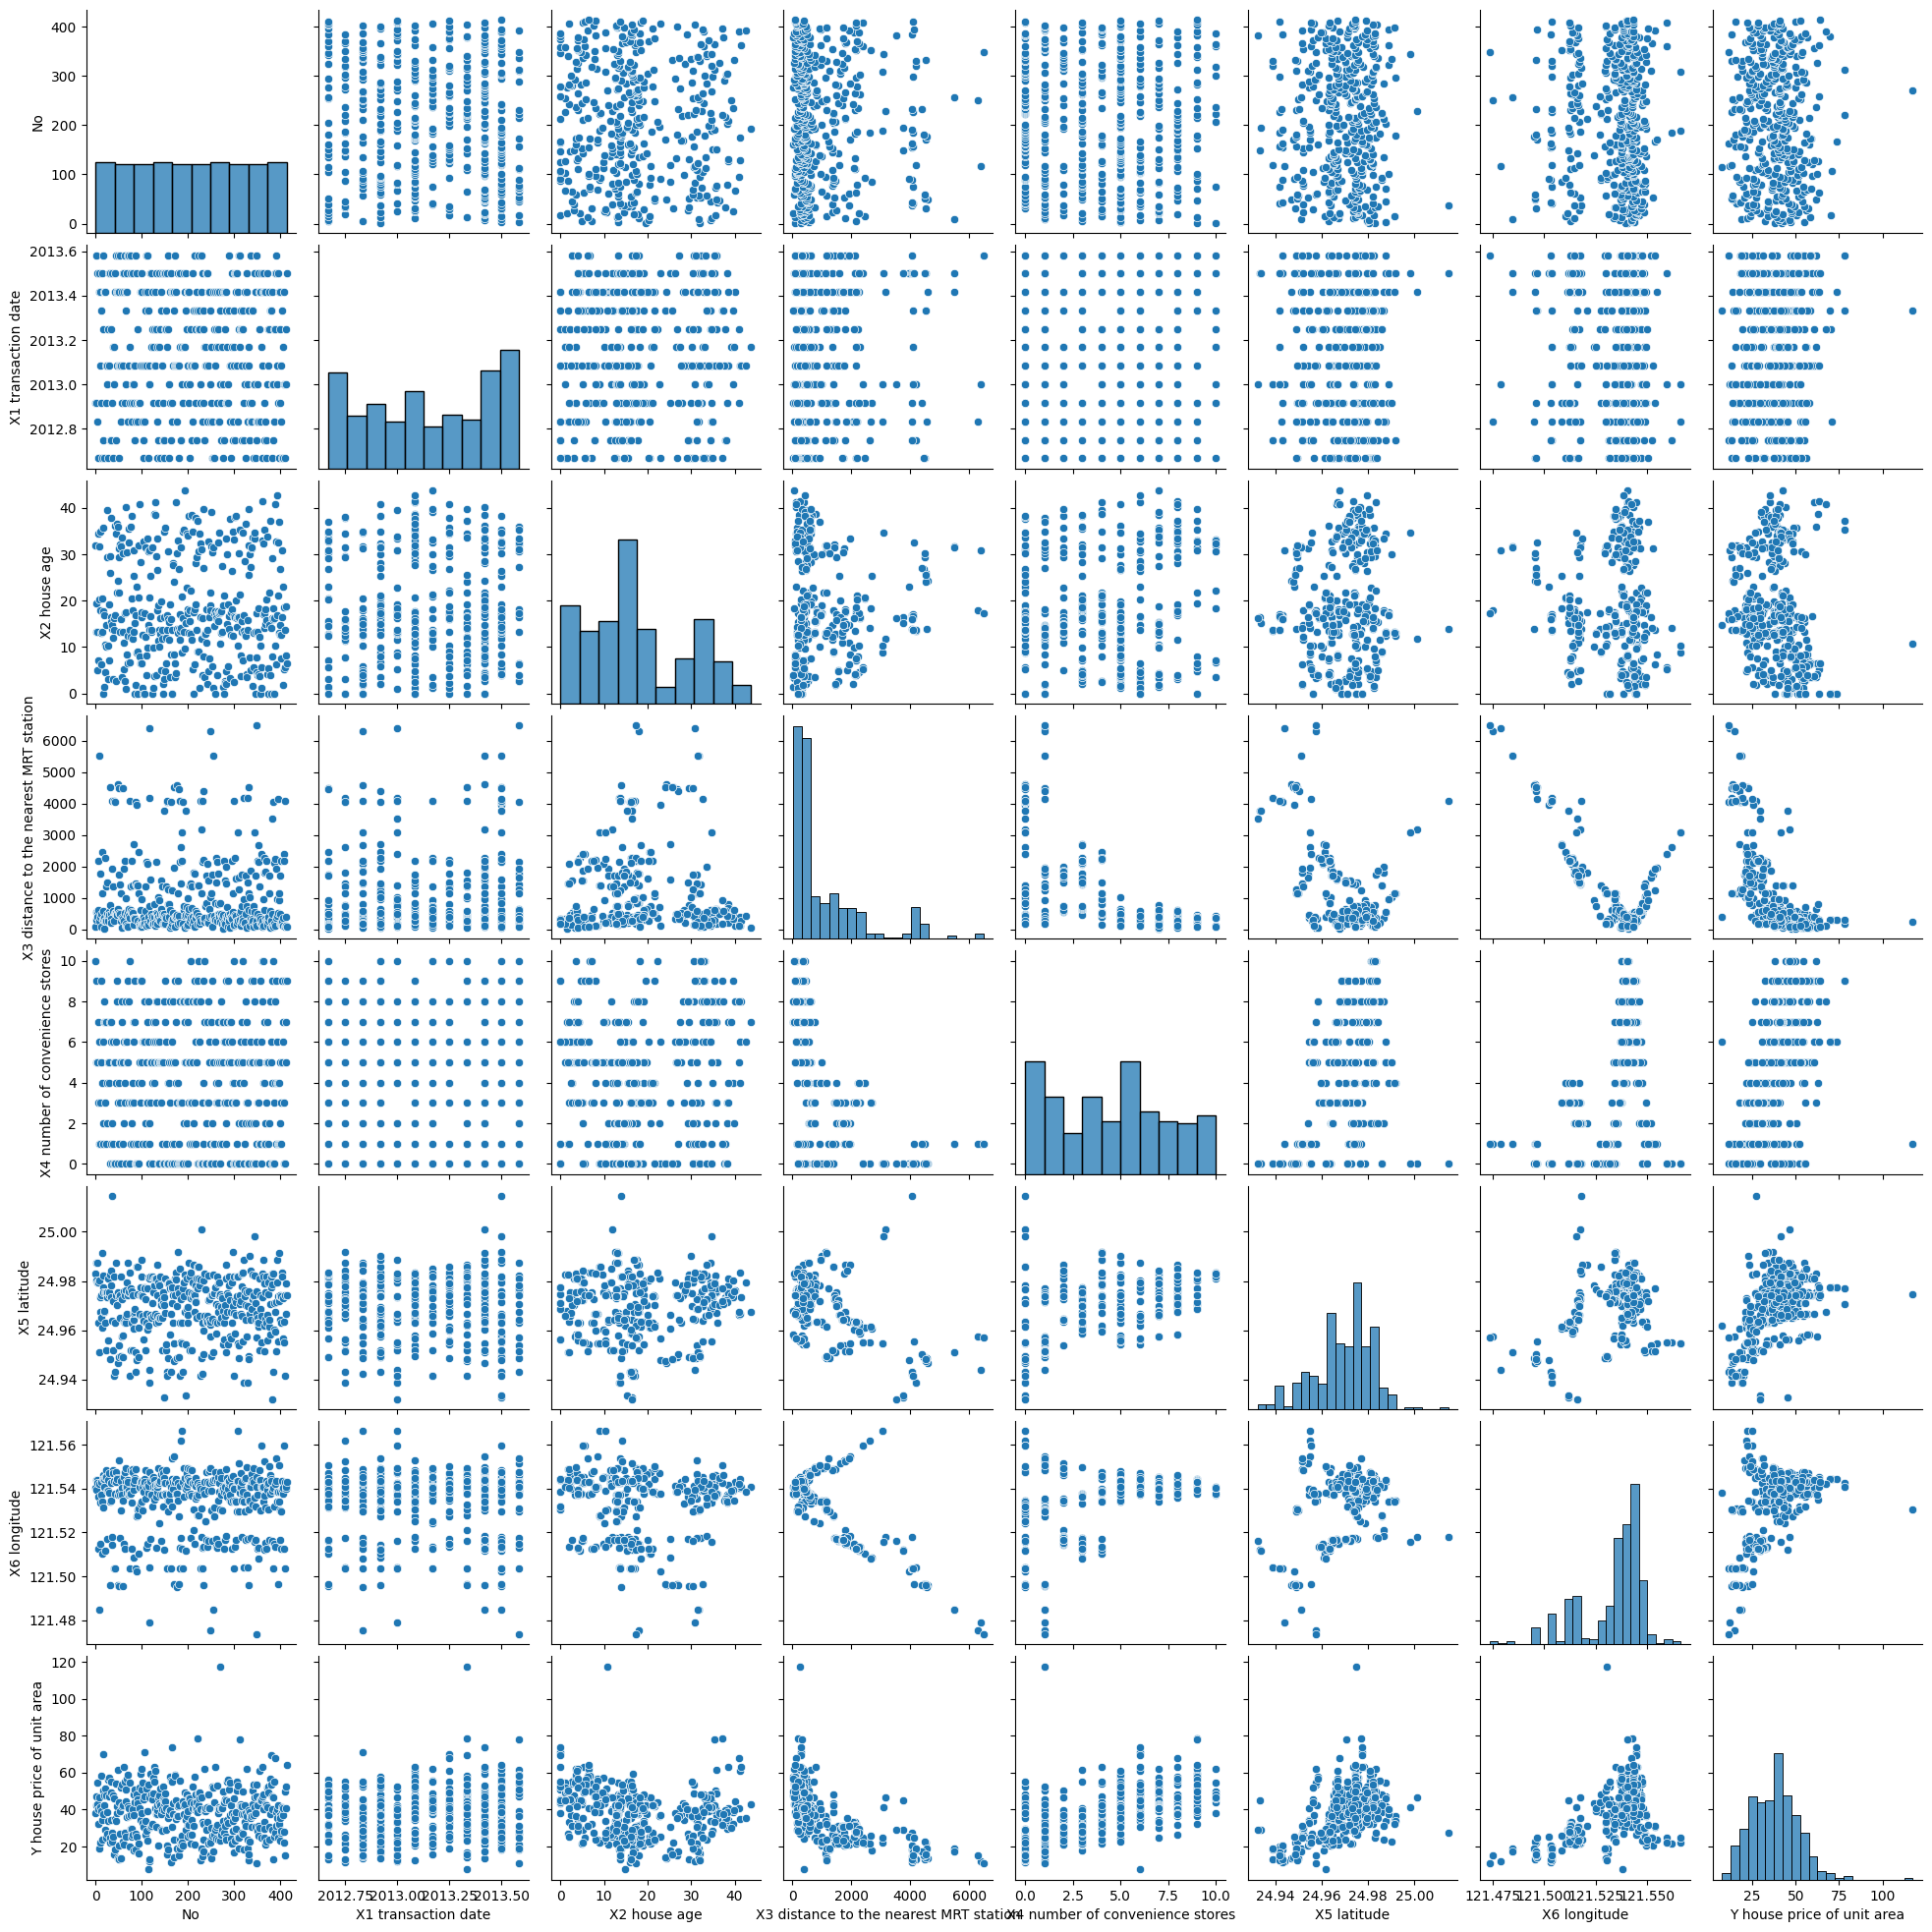

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plot pairwise relationships using Seaborn (Pandas DataFrame)
sns.pairplot(pandas_df)
plt.show()

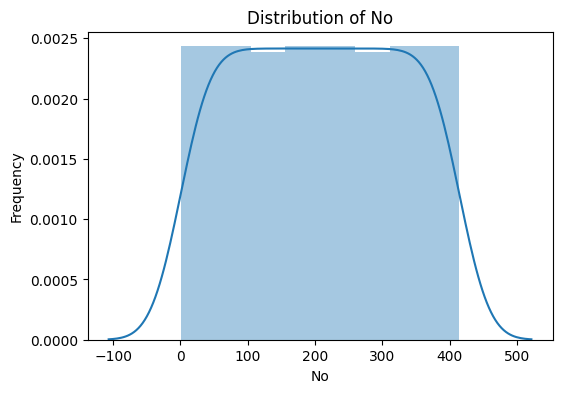

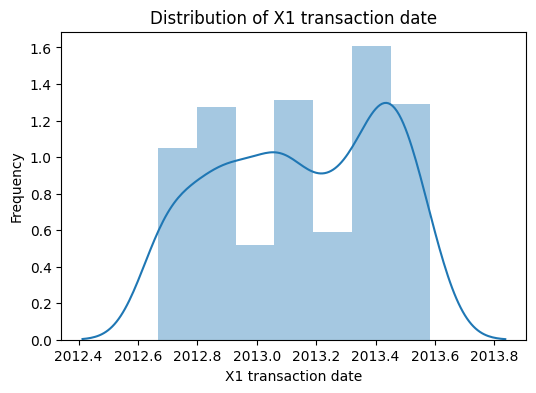

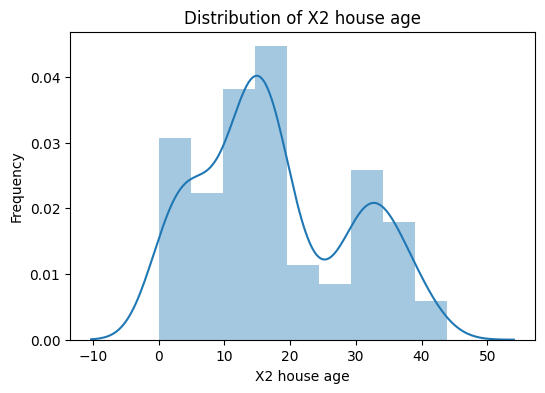

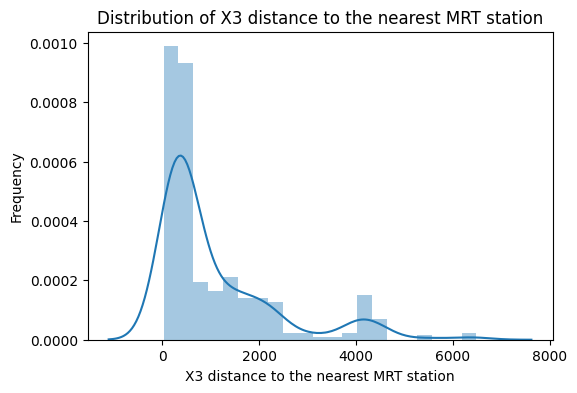

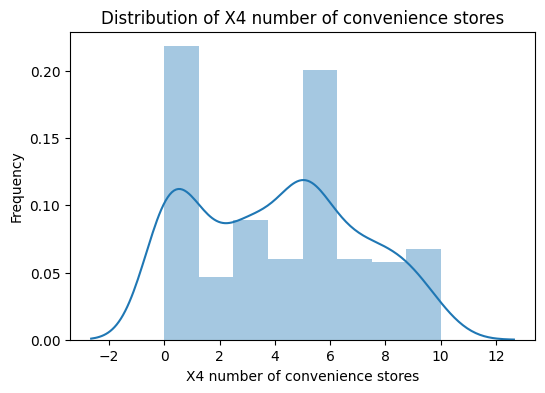

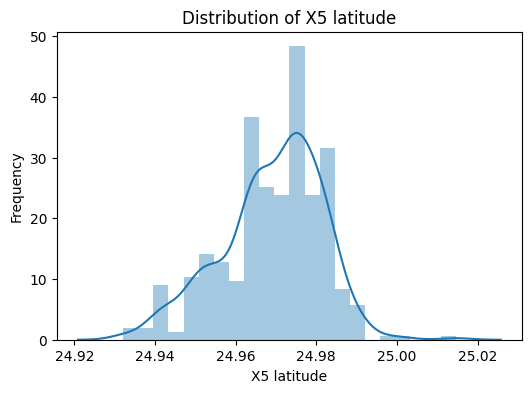

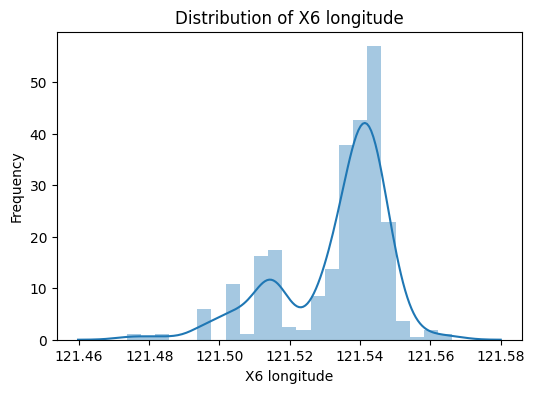

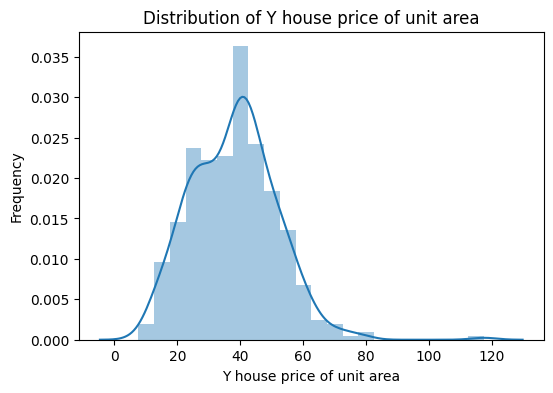

In [37]:
#Distribution of each variable
import warnings
warnings.filterwarnings("ignore")
# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

# Plot distributions for each column
for col in pandas_df.columns:
    plt.figure(figsize=(6, 4))
    sns.distplot(pandas_df[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

**Describing the association between individual variables and the target variable.**

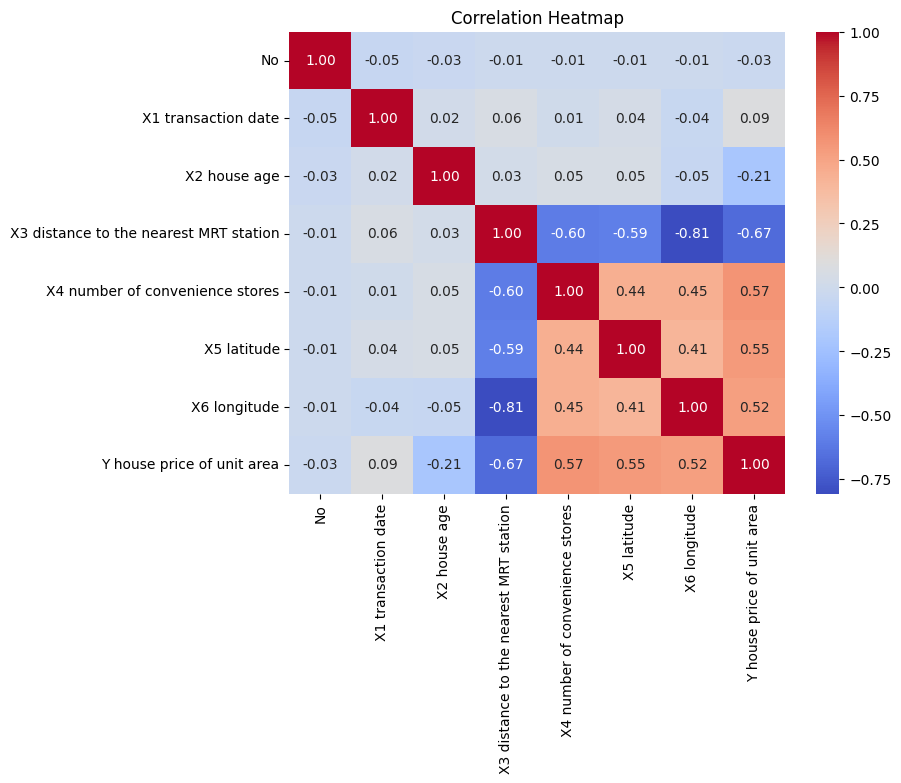

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

df_updated = df.toPandas()

# Calculate correlation matrix
correlation_matrix = df_updated.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Using a heatmap visualization to illustrate linear correlations between variables, employing the Pearson Correlation Coefficient as the measure for assessing these relationships.

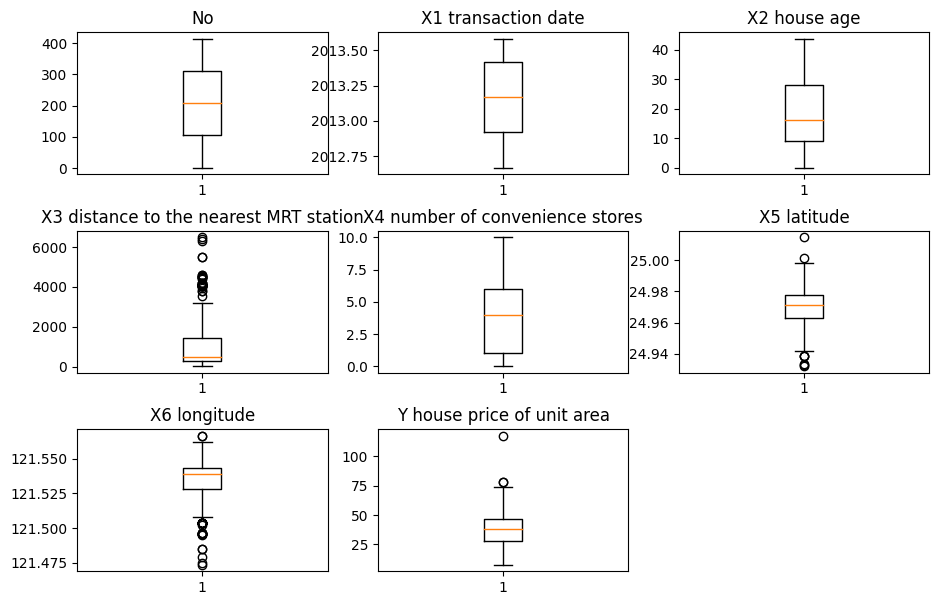

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(11, 7))
plt.subplots_adjust(hspace=0.4)

# Check the number of columns in df_updated
num_columns = df_updated.shape[1]

column_count = 0

for i in range(3):
    for y in range(3):
        if column_count < num_columns:
            ax[i, y].boxplot(df_updated.iloc[:, column_count])
            ax[i, y].set_title(df_updated.columns[column_count])
            column_count += 1
        else:
            # If there are fewer than 9 columns, fill the remaining subplots with blank plots
            ax[i, y].axis('off')

Creating a boxplot to showcase the relationship between variables, relying on the Pearson Correlation Coefficient as the metric for evaluating these associations.

# Feature Transformation

- Split

In [40]:
import numpy as np

In [41]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [42]:
#Assembler

target_variable_name = "csMPa"

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features']
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df

In [43]:
#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove('Y house price of unit area')

In [44]:
features_list

['No',
 'X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude']

In [45]:
# apply the function on our dataframe
assembled_df = assemble_vectors(train, features_list, 'Y house price of unit area')

In [46]:
assembled_df.show()

+--------------------------+--------------------+
|Y house price of unit area|            features|
+--------------------------+--------------------+
|                      37.9|[1.0,2012.917,32....|
|                      42.2|[2.0,2012.917,19....|
|                      47.3|[3.0,2013.583,13....|
|                      54.8|[4.0,2013.5,13.3,...|
|                      43.1|[5.0,2012.833,5.0...|
|                      32.1|[6.0,2012.667,7.1...|
|                      46.7|[8.0,2013.417,20....|
|                      18.8|[9.0,2013.5,31.7,...|
|                      22.1|[10.0,2013.417,17...|
|                      41.4|[11.0,2013.083,34...|
|                      58.1|[12.0,2013.333,6....|
|                      39.3|[13.0,2012.917,13...|
|                      34.3|[15.0,2013.5,13.2...|
|                      50.5|[16.0,2013.583,35...|
|                      70.1|[17.0,2013.25,0.0...|
|                      42.3|[19.0,2013.417,16...|
|                      47.7|[20.0,2012.667,1....|


# Modelling

**a. Linear Regression**

In [47]:
reg = LinearRegression(featuresCol='features', labelCol='Y house price of unit area')
reg_model = reg.fit(assembled_df) # fit model

In [48]:
import pandas as pd
for k, v in assembled_df.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)

features_df['coefficients'] = reg_model.coefficients

features_df

,idx,name,coefficients
0,0,No,-0.004111
1,1,X1 transaction date,3.761689
2,2,X2 house age,-0.311604
3,3,X3 distance to the nearest MRT station,-0.004808
4,4,X4 number of convenience stores,1.058447
5,5,X5 latitude,193.794506
6,6,X6 longitude,-20.085896


In [51]:
#prediction result
pred_result = reg_model.transform(assembled_df)

pred_result.show()

+--------------------------+--------------------+------------------+
|Y house price of unit area|            features|        prediction|
+--------------------------+--------------------+------------------+
|                      37.9|[1.0,2012.917,32....| 47.06366069626529|
|                      42.2|[2.0,2012.917,19....| 48.33321301538308|
|                      47.3|[3.0,2013.583,13....|48.596093972684685|
|                      54.8|[4.0,2013.5,13.3,...| 48.27976233884874|
|                      43.1|[5.0,2012.833,5.0...| 47.63860095856944|
|                      32.1|[6.0,2012.667,7.1...|  33.0973057703759|
|                      46.7|[8.0,2013.417,20....|46.815942246163104|
|                      18.8|[9.0,2013.5,31.7,...| 8.608765374665381|
|                      22.1|[10.0,2013.417,17...|35.199742481016074|
|                      41.4|[11.0,2013.083,34...|  34.0001820704565|
|                      58.1|[12.0,2013.333,6....| 53.77249959833716|
|                      39.3|[13.0,

In [58]:
#Evaluation
reg_summary = reg_model.summary

print('MSE        = ', reg_summary.meanSquaredError)
print('RMSE       = ', reg_summary.rootMeanSquaredError)
print('MAE        = ', reg_summary.meanAbsoluteError)
print('Explained Variance = ', reg_summary.explainedVariance)
print('R squared  = ', reg_summary.r2)

MSE        =  74.60571941123132
RMSE       =  8.63746024079019
MAE        =  5.913618372313601
Explained Variance =  111.98269656692177
R squared  =  0.6001588896529861


The linear regression model demonstrates moderate predictive performance with an MSE of 74.61, RMSE of 8.64, MAE of 5.91, an Explained Variance of 111.98, and an R-squared value of 0.60.

**b. Random Forest Regressor**

In [54]:
rf = RandomForestRegressor(featuresCol="features", labelCol="Y house price of unit area")
rf_model = rf.fit(assembled_df)
# print(reg_model.featureImportances)
# print(reg_model.toDebugString)

In [56]:
#Evaluation
# Make predictions on the test set
predictions = rf_model.transform(assembled_df)

# Selecting the evaluator and computing RMSE
evaluator = RegressionEvaluator(labelCol="Y house price of unit area", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='mae')
mae = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='var')
var = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='Y house price of unit area', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)



print("RMSE on test data: {:.4f}".format(rmse))
print("MSE on test data : {:.4f}".format(mse))
print("MAE on test data : {:.4f}".format(mae))
print("var on test data : {:.4f}".format(var))
print("R-2 on test data : {:.4f}".format(r2))


RMSE on test data: 5.0279
MSE on test data : 25.2798
MAE on test data : 3.6256
var on test data : 134.3328
R-2 on test data : 0.8645


The Decision Tree Regressor exhibits strong performance on the test data with an RMSE of 5.03, MSE of 25.28, MAE of 3.63, explained variance of 134.33, and an impressive R-squared value of 0.8645, signifying a high level of predictive accuracy and a robust fit between predictors and the target variable.

**Conclusion**


The Random Forest Regressor performs better than the Linear Regression model in predicting outcomes for this dataset.

>

*   Smaller errors predictions, RMSE of 5.1280 compared to 8.6375 in Linear Regression.
*   More accurate predictions,  MAE of 3.6604 beats Linear Regression's 5.9136.
*   Better data pattern, Higher R-squared value 0.8591 compared to Linear Regression's 0.6002.
>

In summary, the Random Forest Regressor seems to be a better choice for this dataset. It makes more accurate predictions and does a better job of understanding the data compared to Linear Regression. However, it's important to consider other factors like how computationally intensive it is and how easy it is to understand the model's decisions. Despite needing more computing power, its improved accuracy makes it a good option for predicting outcomes in this dataset.